<a href="https://colab.research.google.com/github/davidguzmanr/Aprendizaje-Profundo/blob/main/Tareas/Tarea-3/Tarea_3_ejercicio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2: redes convolucionales

- **E. David Guzmán Ramírez**
- **Introducción al Aprendizaje Profundo 2021-II**
- **Licenciatura en Ciencia de Datos CU UNAM**

## Ejercicio 1

Entrena modelos de regresión para predecir edades en el conjunto de datos UTKFace. La solución debe cumplir con los siguientes puntos:

- Implementa la tuberı́a de datos usando el conjunto de rostros alineados y recortados https://cloud.xibalba.com.mx/s/d7Z7oWMLfXBjCTX/download.
- Agrega acrecentamiento de datos usando un espejeo horizontal.
- Particiona aleatoriamente en subconjuntos entrenamiento 80 % y prueba 20 %.
- Usando transferencia de conocimiento, entrena un modelo reentrenando solo la última capa.
- Usando transferencia de conocimiento, entrena un modelo reentrenando toda la red.
- Discute el comportamiento de los modelos durante el entrenamiento y los resultados finales en ambos conjuntos.

## Librerías

In [1]:
! pip install torchinfo

In [2]:
# funciones aleatorias
import random

# sistema de archivos
import os
from os.path import join

# flush!
import sys

# procesamiento xml
import xml.etree.ElementTree as ET

# gráficas
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns

# arreglos multidimensionales
import numpy as np
from itertools import islice as take

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
import torchvision.models as models
import torchvision.transforms as transforms
from scipy.io import loadmat
from torch.utils.data import DataLoader, random_split
# from torchvision.datasets import VisionDataset 

# inspección de arquitectura
from torchinfo import summary

# barras de progreso
from tqdm import tqdm, trange
from IPython.display import clear_output

# imágenes
from PIL import Image

sns.set_style('darkgrid')

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Auxiliares

In [4]:
# directorio de datos
DATA_DIR = './datos'

# tamaño del lote
BATCH_SIZE = 32
# tamaño de la imagen
IMG_SIZE = 224

# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# filas y columnas de la cuadrícula 
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Despliega un ejempos en una cuadrícula."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            ax[r, c].axis('off')
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos lote
    display_grid(x, titles, rows, cols, figsize)


def timestamp(fmt='%y%m%dT%H%M%S'):
    """Regresa la marca de tiempo."""
    return datetime.datetime.fromtimestamp(time.time()).strftime(fmt)


def set_seed(seed=42):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# reproducibilidad
set_seed()

## Datos

### Dataset

In [5]:
class UTKFace():
    def __init__(self, root='./data', transform=None, download=False, train=True, seed=42):
        self.root = join(root, 'UTKFace')
        self.transform = transform
        self.train = train
        self.seed = seed
        
        os.makedirs(self.root, exist_ok=True)        
        
        if download:
            self.download()
            
        if not self._check_integrity():
            raise RuntimeError(
                'Dataset not found or corrupted.' +
                'You can use download=True to download it')
            
        filenames = os.listdir(join(self.root, 'UTKFace'))
        # Hacemos un shuffle, se hace in-place
        random.Random(seed).shuffle(filenames)
        
        # 80% para train y 20% para test
        train_size = int(0.8*len(filenames))
                
        if train:
            self.filenames = filenames[0:train_size]
        else:
            self.filenames = filenames[train_size:]
            
    def __len__(self):
        return len(self.filenames)
    
    def _check_integrity(self):
        return os.path.exists(self.root)

    def download(self):
        tvu.download_and_extract_archive(
            url='https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download',
            download_root=self.root,
            filename='UTKFace.tar.gz')
        
    def get_age(self, filename):
        age = filename.split('_')[0]
        return float(age)
    
    def __getitem__(self, index):
        img_path = join(self.root, 'UTKFace', self.filenames[index])
        
        img = Image.open(img_path)
        
        if self.transform is not None:
            img = self.transform(img)
            
        age = self.get_age(self.filenames[index])
        
        return img, age

### Acrecentamiento de datos

Se agregará un espejeo horizontal, además, como se usarán modelos preentrenados con ImageNet necesitamos aplicar el preprocesamiento que le hacen a sus imágenes (ver [Torchvision models](https://pytorch.org/vision/stable/models.html)).

In [6]:
train_transform = transforms.Compose([transforms.Resize(224),            # tamaño de ImageNet
                                      transforms.RandomHorizontalFlip(), # espejeo horizontal
                                      transforms.ToTensor(),             # [0,255] -> [0,1]
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                           std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(224),            # tamaño de ImageNet
                                     transforms.ToTensor(),             # [0,255] -> [0,1]
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                          std=[0.229, 0.224, 0.225])])

### Dataloaders

In [13]:
train_dataset = UTKFace(root='./data', transform=train_transform, download=True, train=True)

train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=2, drop_last=True)


Extracting ./data/UTKFace/UTKFace.tar.gz to ./data/UTKFace


In [14]:
test_dataset = UTKFace(root='./data', transform=test_transform, download=False, train=False)

test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=2, drop_last=True)

In [15]:
len(train_dataloader), len(test_dataloader)

(592, 148)

x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.float64


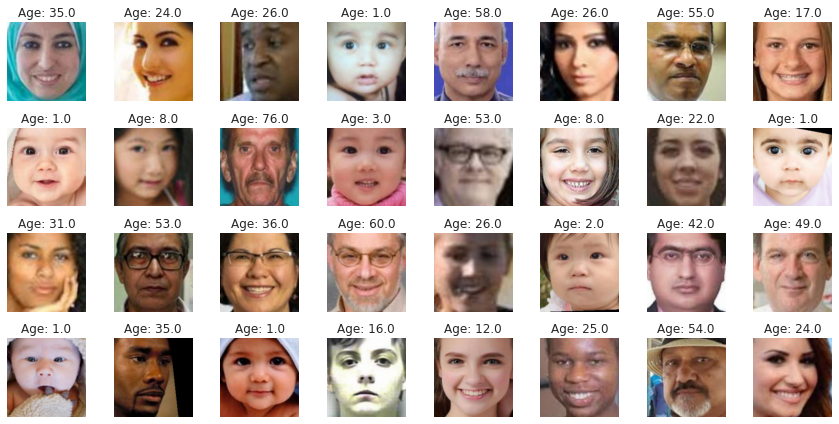

In [17]:
x, y = next(iter(train_dataloader))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

titles = [f'Age: {age}' for age in y]
display_batch(x, titles, ROWS, COLS)

## Entrenamiento

### Modelo

Usaré [ResNet-18](https://pytorch.org/hub/pytorch_vision_resnet/) como modelo preentrenado.

In [ ]:
class AgeModel(nn.Module):
    def __init__(self):
        # Inicilización del objeto padre
        super(AgeModel, self).__init__()
        
        # Cargamos el modelo preentrenado
        self.cnn = models.resnet18(pretrained=True)
        # Reemplazamos la fc para quedarnos sólo con las features 
        self.cnn.fc = nn.Identity()
        
        # Creamos nuestra capa para regressión
        in_features = 512 
        self.regression = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, 1))
        
    def forward(self, x):
        # [batch_size, 3, 224, 224] -> [batch_size, 1280]
        x = self.cnn(x)
        x = self.regression(x)
        
        return x

### Entrenando sólo la última capa

In [ ]:
model_last_layer = AgeModel()

In [ ]:
# Congelado de parámetros de la CNN
for param in model_last_layer.cnn.parameters():
    param.requires_grad = False
    
# Congelado de estadísticas de todo el modelo
_ = model_last_layer.eval()

Podemos observar que en efecto sólo la última capa tiene parámetros entrenables.

In [ ]:
summary(model_last_layer, input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [1, 512]                  --
|    └─Conv2d: 2-1                       [1, 64, 112, 112]         (9,408)
|    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         (128)
|    └─ReLU: 2-3                         [1, 64, 112, 112]         --
|    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
|    └─Sequential: 2-5                   [1, 64, 56, 56]           --
|    |    └─BasicBlock: 3-1              [1, 64, 56, 56]           (73,984)
|    |    └─BasicBlock: 3-2              [1, 64, 56, 56]           (73,984)
|    └─Sequential: 2-6                   [1, 128, 28, 28]          --
|    |    └─BasicBlock: 3-3              [1, 128, 28, 28]          (230,144)
|    |    └─BasicBlock: 3-4              [1, 128, 28, 28]          (295,424)
|    └─Sequential: 2-7                   [1, 256, 14, 14]          --
|    |    └─BasicBlock: 3-5              [1, 256, 1

In [ ]:
model_last_layer = model_last_layer.to(device)

In [ ]:
# optimizador
opt = optim.Adam(model_last_layer.parameters(), lr=1e-3)

train_loss, test_loss = [], []

# ciclo de entrenamiento
EPOCHS = 20
for epoch in range(EPOCHS):
    # Limpiamos las salidas de las épocas anteriores
    clear_output(wait=True)
    
    # capas de regresión en modo de entrenamiento
    model_last_layer.regression.train()
    
    # entrenamiento de una época
    mses = []
    for x, y_true in tqdm(train_dataloader, desc=f'E{epoch:2d} Train'):
        # movemos a dispositivo
        x = x.to(device)
        y_true = y_true.to(device)
        # computamos la predicción
        y_pred = model_last_layer(x)
        # computamos la pérdida
        loss = F.mse_loss(y_pred, y_true.type(torch.float32).unsqueeze(1))
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actualizamos parámetros
        opt.step()    
        # guardamos históricos
        mses.append(loss.item())
        
    # guardamos históricos   
    train_loss.append(np.mean(mses))

    # capas de regresión en modo de evaluación
    model_last_layer.regression.eval()    
    
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():
        
        mses = []
        # validación de la época
        for x, y_true in tqdm(test_dataloader, desc=f'E{epoch:2d} Test '):
            # movemos a dispositivo
            x = x.to(device)
            y_true = y_true.to(device)
            # computamos la predicción
            y_pred = model_last_layer(x)
            # computamos la pérdida
            mse = F.mse_loss(y_pred, y_true.type(torch.float32).unsqueeze(1))
            # guardamos históricos
            mses.append(mse.item())

        # promediamos métricas
        mse = np.mean(mses)
        test_loss.append(mse)
        
    # imprimimos métricas
    print(f'E{epoch:2} MSE test ={mse:7.2f}')
    sys.stdout.flush()

E19 Test : 100%|██████████| 148/148 [00:03<00:00, 40.28it/s]

E19 MSE test = 140.29


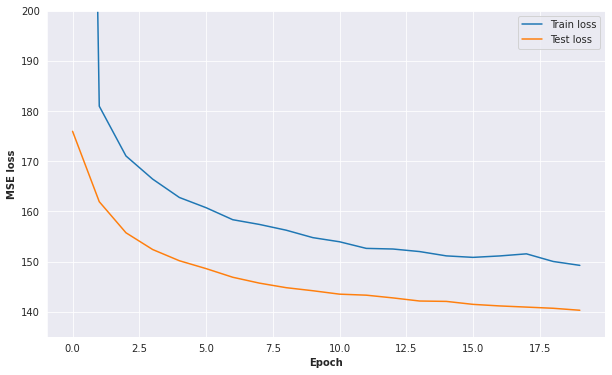

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(train_loss, label='Train loss')
plt.plot(test_loss, label='Test loss')

plt.xlabel('Epoch', weight='bold')
plt.ylabel('MSE loss', weight='bold')
plt.ylim(135, 200)

plt.legend()
plt.show()

Ahora vemos algunas imágenes.

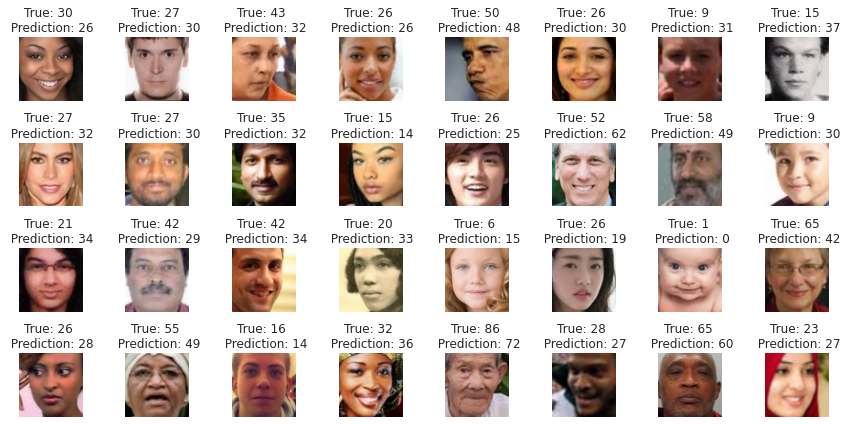

In [ ]:
x, y_true = next(iter(test_dataloader))
y_pred = model_last_layer(x.to(device))
y_pred = y_pred.cpu().flatten()

titles = [f'True: {int(true)} \n Prediction: {int(pred)}' for (true, pred) in zip(y_true, y_pred)]

display_batch(x, titles, ROWS, COLS)

### Entrenando toda la red

In [ ]:
model_all_layers = AgeModel()

Ahora todas las capas son entrenables.

In [ ]:
summary(model_all_layers, input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [1, 512]                  --
|    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
|    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
|    └─ReLU: 2-3                         [1, 64, 112, 112]         --
|    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
|    └─Sequential: 2-5                   [1, 64, 56, 56]           --
|    |    └─BasicBlock: 3-1              [1, 64, 56, 56]           73,984
|    |    └─BasicBlock: 3-2              [1, 64, 56, 56]           73,984
|    └─Sequential: 2-6                   [1, 128, 28, 28]          --
|    |    └─BasicBlock: 3-3              [1, 128, 28, 28]          230,144
|    |    └─BasicBlock: 3-4              [1, 128, 28, 28]          295,424
|    └─Sequential: 2-7                   [1, 256, 14, 14]          --
|    |    └─BasicBlock: 3-5              [1, 256, 14, 14]      

In [ ]:
model_all_layers = model_all_layers.to(device)

In [ ]:
# optimizador
opt = optim.Adam(model_all_layers.parameters(), lr=1e-3)

train_loss, test_loss = [], []

# ciclo de entrenamiento
EPOCHS = 20
for epoch in range(EPOCHS):
    # Limpiamos las salidas de las épocas anteriores
    clear_output(wait=True)
    
    # Todas las capas en entrenamiento
    model_all_layers.train()
    
    # entrenamiento de una época
    mses = []
    for x, y_true in tqdm(train_dataloader, desc=f'E{epoch:2d} Train'):
        # movemos a dispositivo
        x = x.to(device)
        y_true = y_true.to(device)
        # computamos la predicción
        y_pred = model_all_layers(x)
        # computamos la pérdida
        loss = F.mse_loss(y_pred, y_true.type(torch.float32).unsqueeze(1))
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actualizamos parámetros
        opt.step()    
        # guardamos históricos
        mses.append(loss.item())
        
    # guardamos históricos   
    train_loss.append(np.mean(mses))

    # Todas las capas en evaluación
    model_all_layers.eval()    
    
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():
        
        mses = []
        # validación de la época
        for x, y_true in tqdm(test_dataloader, desc=f'E{epoch:2d} Test '):
            # movemos a dispositivo
            x = x.to(device)
            y_true = y_true.to(device)
            # computamos la predicción
            y_pred = model_all_layers(x)
            # computamos la pérdida
            mse = F.mse_loss(y_pred, y_true.type(torch.float32).unsqueeze(1))
            # guardamos históricos
            mses.append(mse.item())

        # promediamos métricas
        mse = np.mean(mses)
        test_loss.append(mse)
        
    # imprimimos métricas
    print(f'E{epoch:2} MSE test ={mse:7.2f}')
    sys.stdout.flush()

E19 Test : 100%|██████████| 148/148 [00:03<00:00, 40.33it/s]

E19 MSE test =  58.74


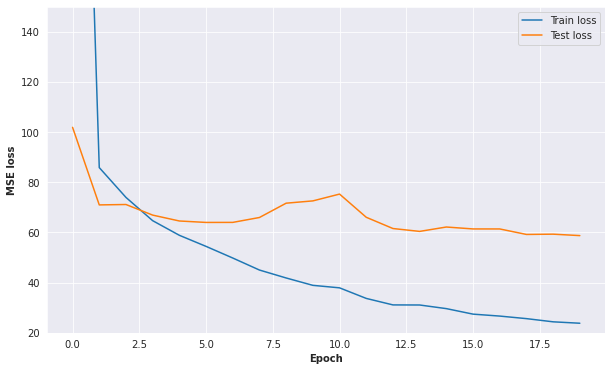

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(train_loss, label='Train loss')
plt.plot(test_loss, label='Test loss')

plt.xlabel('Epoch', weight='bold')
plt.ylabel('MSE loss', weight='bold')
plt.ylim(20, 150)

plt.legend()
plt.show()

Ahora vemos algunas imágenes.

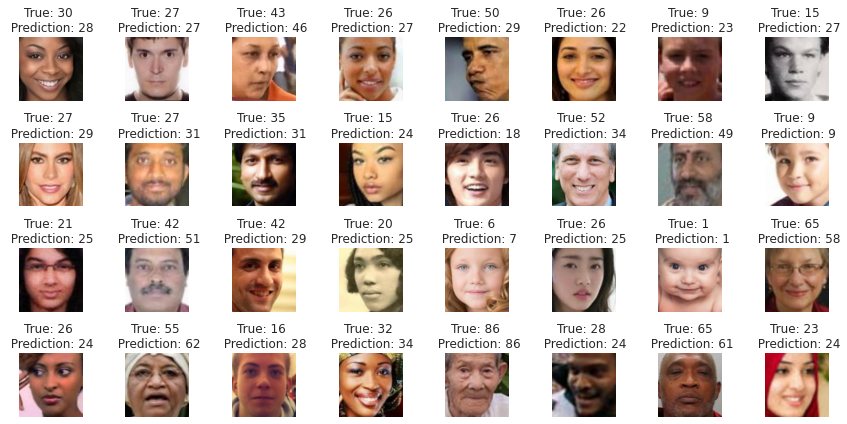

In [ ]:
x, y_true = next(iter(test_dataloader))
y_pred = model_all_layers(x.to(device))
y_pred = y_pred.cpu().flatten()

titles = [f'True: {int(true)} \n Prediction: {int(pred)}' for (true, pred) in zip(y_true, y_pred)]

display_batch(x, titles, ROWS, COLS)

## Discusión

En ambas redes las predicciones son buenas, sin embargo, parece ser que la red completamente reentrenada cuenta con mejores resultados, lo que se puede observar en la gráfica de la pérdida del modelo completamente reentrenado. Una explicación a ésto es que el modelo completamente reentrenado puede afinar sus parámetros para extraer mejores características para predecir la edad.

Sin embargo, claramente es más tardado entrenar la red completa, de modo que depende de la tarea a realizar la estrategia que se debe tomar.